# Methodology

- [How Neural Networks work](https://docs.google.com/presentation/d/1AAEFCgC0Ja7QEl3-wmuvIizbvaE-aQRksc7-W8LR2GY/edit#slide=id.p)
- [How LSTM and RNNs work](https://docs.google.com/presentation/d/1hqYB3LRwg_-ntptHxH18W1ax9kBwkaZ1Pa_s3L7R-2Y/edit#slide=id.g1f8068b839_0_1013)

- [Keras中文文档](https://keras-cn.readthedocs.io/en/latest/layers/recurrent_layer/)


＊＊＊＊ [通过keras例子理解LSTM 循环神经网络(RNN)](https://blog.csdn.net/zwqjoy/article/details/80493341?utm_source=blogxgwz9&utm_medium=distribute.pc_relevant.none-task-blog-2~default~baidujs_title~default-0.no_search_link&spm=1001.2101.3001.4242.1)

[循環神經網絡 RNN、LSTM、GRU](https://kknews.cc/zh-tw/code/rnja46v.html)

In [ ]:
#@title import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

# 固定亂數種子，使每次執行產生的亂數都一樣
np.random.seed(7)

# Use Case

- [進入 NLP 世界的最佳橋樑：寫給所有人的自然語言處理與深度學習入門指南](https://leemeng.tw/shortest-path-to-the-nlp-world-a-gentle-guide-of-natural-language-processing-and-deep-learning-for-everyone.html#%E6%9C%89%E8%A8%98%E6%86%B6%E7%9A%84%E5%BE%AA%E7%92%B0%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF_1)
 

In [ ]:
# Colab and Google Sheets — Surprisingly Powerful Combination for Data Science
# https://medium.com/analytics-vidhya/colab-and-google-sheets-surprisingly-powerful-combination-for-data-science-part-1-bbbb11cbd8e

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
import pandas as pd

train_path = '/content/drive/MyDrive/Colab Notebooks/res/fake_news/train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/res/fake_news/test.csv'
df_raw = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(df_raw.shape)
print(test.shape)
df_raw.head()

(320552, 8)
(80126, 7)


,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
0,0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,2,2,5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
4,9,6,7,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,agreed


In [ ]:
cols = ['title1_zh', 
        'title2_zh', 
        'label']
train = df_raw.loc[:, cols].sample(50000)
train.head(3)

,title1_zh,title2_zh,label
307668,股票一旦出现“内盘外盘”试盘信号，定是大牛股，打死也不要卖,一旦股票出现“内盘外盘”洗盘信号，定是大牛股，打死也不要卖,agreed
64873,交通解说：不系安全带每次罚款50不计分，高速公路每次50记2分,后排乘客不系安全带罚款300元，车主还要扣3分，珠海已经实施,agreed
14311,400多大学生借校园贷不还 谁更荒唐？,“几十名大学生神秘消失武汉”系谣言！杜撰者被行拘,unrelated


# 文本分詞

文本分詞（Text Segmentation）是一個將一連串文字切割成多個有意義的單位的步驟。這單位可以是

- 一個中文漢字 / 英文字母（Character）
- 一個中文詞彙 / 英文單字（Word）
- 一個中文句子 / 英文句子（Sentence）

依照不同的 NLP 任務會有不同切割需求，但很常見的切法是以單字（Word）為單位，也就是 Word Segmentation。

In [ ]:
import jieba.posseg as pseg

def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([
        word for word, flag in words if flag != 'x'])

In [ ]:
train['title1_tokenized'] = train.loc[:, 'title1_zh'].apply(jieba_tokenizer)
train['title2_tokenized'] = train.loc[:, 'title2_zh'].apply(jieba_tokenizer)

train.iloc[:, [0, 3]].head()

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


,title1_zh,title1_tokenized
307668,股票一旦出现“内盘外盘”试盘信号，定是大牛股，打死也不要卖,股票 一旦 出现 内盘 外盘 试盘 信号 定 是 大牛股 打死 也 不要 卖
64873,交通解说：不系安全带每次罚款50不计分，高速公路每次50记2分,交通 解说 不系 安全带 每次 罚款 50 不 计分 高速公路 每次 50 记 2 分
14311,400多大学生借校园贷不还 谁更荒唐？,400 多 大学生 借 校园 贷 不 还 谁 更 荒唐
167293,岑溪市人民医院有人跳楼身亡,岑溪市 人民 医院 有人 跳楼 身亡
138308,大妈60岁都不长斑点皱纹，竟是洗完脸后常涂抹这种小颗粒,大妈 60 岁 都 不长 斑点 皱纹 竟是 洗完 脸 后 常 涂抹 这种 小 颗粒


我們可以分 4 個步驟將手上的新聞標題全部轉為數字序列：

1. 將已被斷詞的新聞標題 A 以及新聞標題 B 全部倒在一起
1. 建立一個空字典
1. 查看所有新聞標題，裏頭每出現一個字典裡頭沒有的詞彙，就為該詞彙指定一個字典裡頭還沒出現的索引數字，並將該詞彙放入字典
1. 利用建好的字典，將每個新聞標題裡頭包含的詞彙轉換成數字

這種文字前處理步驟因為出現頻率實在太過頻繁，Keras 有專門的文字前處理模組來提升我們的效率：

In [ ]:
import keras
MAX_NUM_WORDS = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)

Tokenizer 顧名思義，即是將一段文字轉換成一系列的詞彙（Tokens），並為其建立字典。這邊的 num_words=10000 代表我們限制字典只能包含 10,000 個詞彙，一旦字典達到這個大小以後，剩餘的新詞彙都會被視為 Unknown，以避免字典過於龐大。

如同上述的步驟 1，我們得將新聞 A 及新聞 B 的標題全部聚集起來，為它們建立字典：

In [ ]:
corpus_x1 = train.title1_tokenized
corpus_x2 = train.title2_tokenized
corpus = pd.concat([corpus_x1, corpus_x2])

print(corpus.shape)

(100000,)


因為訓練集有大約 32 萬列（Row）的成對新聞（每一列包含 2 筆新聞：A & B），因此將所有新聞放在一起的話，就有 2 倍的大小。而這些文本的集合在習慣上被稱作語料庫（Text Corpus），代表著我們有的所有文本數據。

以下是我們語料庫的一小部分：

In [ ]:
pd.DataFrame(corpus.iloc[:5], columns=['title'])

,title
307668,股票 一旦 出现 内盘 外盘 试盘 信号 定 是 大牛股 打死 也 不要 卖
64873,交通 解说 不系 安全带 每次 罚款 50 不 计分 高速公路 每次 50 记 2 分
14311,400 多 大学生 借 校园 贷 不 还 谁 更 荒唐
167293,岑溪市 人民 医院 有人 跳楼 身亡
138308,大妈 60 岁 都 不长 斑点 皱纹 竟是 洗完 脸 后 常 涂抹 这种 小 颗粒


有了語料庫以後，接下來就是呼叫 tokenizer 為我們查看所有文本，並建立一個字典（步驟 2 & 3）

In [ ]:
tokenizer.fit_on_texts(corpus)

以我們的語料庫大小來說，這大約需時 10 秒鐘。而等到 tokenizer 建好字典以後，我們可以進行上述第 4 個步驟，請 tokenizer 利用內部生成的字典分別將我們的新聞標題 A 與 新聞 B 轉換成數字序列：

In [ ]:
x1_train = tokenizer.texts_to_sequences(corpus_x1)
x2_train = tokenizer.texts_to_sequences(corpus_x2)

讓我們看看結果：

In [ ]:
print(len(x1_train))

x1_train[:1]

50000


[[864, 1377, 223, 562, 999, 3, 7887, 893, 34, 109, 503]]

x1_train 為一個 Python list，裡頭包含了每一筆假新聞標題 A 對應的數字序列。

讓我們利用 tokenizer.index_word 來將索引數字對應回本來的詞彙：

In [ ]:
for seq in x1_train[:1]:
    print([tokenizer.index_word[idx] for idx in seq])

['股票', '一旦', '出现', '信号', '定', '是', '大牛股', '打死', '也', '不要', '卖']


到此為止，我們已經將所有新聞標題轉換成電腦容易處理的數字序列，進入下個步驟！

# 序列的 Zero Padding
雖然我們已經將每個新聞標題的文本轉為一行行的數字序列，你會發現每篇標題的序列長度並不相同：

In [ ]:
for seq in x1_train[:10]:
    # assert len(seq) == 20
    print(len(seq), seq[:5], ' ...')

11 [864, 1377, 223, 562, 999]  ...
12 [1535, 5193, 8189, 5425, 383]  ...
11 [1635, 38, 1528, 1492, 3636]  ...
6 [1646, 696, 393, 207, 560]  ...
16 [845, 295, 28, 15, 5859]  ...
18 [7, 3592, 111, 6891, 7]  ...
13 [6174, 5, 136, 146, 137]  ...
15 [1493, 28, 1, 9270, 1264]  ...
14 [575, 160, 170, 616, 21]  ...
19 [504, 269, 21, 111, 9]  ...


最長的序列甚至達到 61 個詞彙：

In [ ]:
max_seq_len = max([ len(seq) for seq in x1_train])
max_seq_len

61

而為了方便之後的 NLP 模型處理（見[循環神經網路](https://leemeng.tw/shortest-path-to-the-nlp-world-a-gentle-guide-of-natural-language-processing-and-deep-learning-for-everyone.html#%E6%9C%89%E8%A8%98%E6%86%B6%E7%9A%84%E5%BE%AA%E7%92%B0%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF_1)一章），一般會設定一個 MAX_SEQUENCE_LENGTH 來讓所有序列的長度一致。

長度超過此數字的序列尾巴會被刪掉；而針對原來長度不足的序列，我們則會在詞彙前面補零。Keras 一樣有個方便函式 pad_sequences 來幫助我們完成這件工作：

In [ ]:
MAX_SEQUENCE_LENGTH = 20

x1_train = keras.preprocessing.sequence.pad_sequences(x1_train, maxlen=MAX_SEQUENCE_LENGTH)
x2_train = keras.preprocessing.sequence.pad_sequences(x2_train, maxlen=MAX_SEQUENCE_LENGTH)

一般來說 MAX_SEQUENCE_LENGTH 可以設定成最長序列的長度（此例中的 61）。但這邊為了讓模型可以只看前 20 個詞彙就做出判斷以節省訓練時間，我們先暫時使用 20 這個數字。

讓我們看看經過 Zero Padding 的第一篇假新聞標題 A 變成什麼樣子：

In [ ]:
x1_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,  864, 1377,
        223,  562,  999,    3, 7887,  893,   34,  109,  503], dtype=int32)

你可以清楚看到，因為該新聞標題原本的序列長度並沒有達到剛剛設定的 MAX_SEQUENCE_LENGTH，因此在總長度為 20 的序列中，前面 6 個值被 Keras 補上 0 以說明該序列中的前 6 個詞彙並不存在。

我們還可以發現，所有的新聞標題都被轉成長度為 20 的數字序列了：

In [ ]:
for seq in x1_train + x2_train:
    assert len(seq) == 20
    
# print("所有新聞標題的序列長度皆為 20 !")

再看一次轉換後的新聞標題：

In [ ]:
x1_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,  864, 1377,
         223,  562,  999,    3, 7887,  893,   34,  109,  503],
       [   0,    0,    0,    0,    0,    0,    0,    0, 1535, 5193, 8189,
        5425,  383,  338,   10, 5425,  338, 3888,   76,  283],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1635,   38,
        1528, 1492, 3636, 4132,   10,   22,  176,  144, 8897],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 1646,  696,  393,  207,  560,  686],
       [   0,    0,    0,    0,  845,  295,   28,   15, 5859,  758, 1283,
         442, 6017,  290,   35,  400, 6018,  170,  101, 7610]],
      dtype=int32)

在這邊，可以看到前 5 個新聞標題都已經各自被轉換為長度為 20 的數字序列，而序列裡頭的每個數字則對應到字典裡頭一個特定的 Token，整整齊齊。


到此為止，我們已經將原本以自然語言呈現的新聞標題轉換成機器容易理解的數字序列了。
不過，別忘了還有 label 這個文字欄位等著我們的處理。

# 將正解做 One-hot Encoding

到目前為止，我們已經將所有的新聞標題以數字型態表示，只剩分類欄位 label 要進行從文本到數字的轉換了：

In [ ]:
train.label[:5]

307668       agreed
64873        agreed
14311     unrelated
167293    unrelated
138308    unrelated
Name: label, dtype: object

不過 label 的處理相對簡單。跟新聞標題相同，我們一樣需要一個字典將分類的文字轉換成索引：

In [ ]:
import numpy as np 

# 定義每一個分類對應到的索引數字
label_to_index = {
    'unrelated': 0, 
    'agreed': 1, 
    'disagreed': 2
}

# 將分類標籤對應到剛定義的數字
y_train = train.label.apply(lambda x: label_to_index[x])

y_train = np.asarray(y_train).astype('float32')

y_train[:5]

array([1., 1., 0., 0., 0.], dtype=float32)

現在每個分類的文字標籤都已經被轉成對應的數字，接著讓我們利用 Keras 做 One Hot Encoding：

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)

y_train[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

上述矩陣的每一列即為 1 個 label，而你可以看到現在每個 label 都從 1 個數字變成一個 3 維的向量（Vector）。

每 1 維度則對應到 1 個分類：

- **[1, 0, 0]** 代表 label 為 unrelated
- **[0, 1, 0]** 代表 label 為 agreed
- **[0, 0, 1]** 代表 label 為 disagreed

用這樣的方式表達 label 的好處是我們可以把分類結果想成機率分佈。**[1, 0, 0]** 就代表一組新聞標題 A、B 為 **unrelated** 的機率等於 100 %。
</br>
</br>
One Hot Encoding 示意圖
</br>
<img src="https://leemeng.tw/images/nlp-kaggle-intro/one-encoding.jpg" alt="drawing" width="600"/>


在[決定如何衡量模型的表現](https://leemeng.tw/shortest-path-to-the-nlp-world-a-gentle-guide-of-natural-language-processing-and-deep-learning-for-everyone.html#%E6%B1%BA%E5%AE%9A%E5%A6%82%E4%BD%95%E8%A1%A1%E9%87%8F%E6%A8%A1%E5%9E%8B%E7%9A%84%E8%A1%A8%E7%8F%BE)一節我們會看到，給定一組新聞標題 A、B，我們的模型會預測此成對標題屬於每個分類的機率值，比方說 **[0.7, 0.2, 0.1]**。而此預測結果代表模型認為這 2 個新聞標題的關係有 70 % 的機率為 unrelated、20 % 的機率是 **agreed** 而 10 % 為 **disagreed**。

因此，如果正解也事先用同樣的方式表達的話，會讓我們比較好計算以下兩者之間的差距：

正確的分類的機率分佈（**[1, 0, 0]**）
模型預測出的機率分佈（**[0.7, 0.2, 0.1]**）
在知道預測結果跟正確解答之間差距多少之後，深度學習模型就會自動修正學習方向，想盡辦法拉近這個差距。

好，到此為止所有的數據都已經被我們轉換成方便機器使用的格式了。最後，讓我們將整個資料集拆成訓練資料集 & 驗證資料集 以方便之後測試模型的效能。

# 切割訓練資料集 & 驗證資料集

這部分很簡單，我們只需決定要將整個訓練資料集（Training Set）的多少比例切出來當作驗證資料集（Validation Set）。此例中我們用 10 %。

但為何要再把本來的訓練資料集切成 2 個部分呢？

一般來說，我們在訓練時只會讓模型看到訓練資料集，並用模型沒看過的驗證資料集來測試該模型在真實世界的表現。（畢竟我們沒有測試資料集的答案）

</br>
我們會反覆在 Train / Valid Set 上訓練並測試模型，最後用 Test Set 一決生死
</br>
<img src="https://leemeng.tw/images/nlp-kaggle-intro/train-valid-test-split.png" alt="drawing" width="600"/>
</br>

等到模型在驗證資料集也表現得夠好後，便在最終的測試資料集（Test Set）進行最後一次的預測並將該結果上傳到 Kaggle。

要了解為何我們需要驗證資料集可以查看這邊的討論。

簡而言之，當你多次利用驗證資料集的預測結果以修正模型，並讓它在該資料集表現更好時，過適（Overfitting）的風險就已經產生了。

</br>
反覆利用驗證資料集的結果來修正模型表現，事實上就等於讓模型「偷看」到驗證資料集本身的資訊了

儘管你沒有直接讓模型看到驗證資料集（Validation Set）內的任何數據，你還是間接地洩漏了該資料集的重要資訊：你讓模型知道怎樣的參數設定會讓它在該資料集表現比較好，亦或表現較差。

</br>
因此有一個完全跟模型訓練過程獨立的測試資料集（Test Set）就顯得重要許多了。（這也是為何我到現在都還沒有碰它的原因）

機器學習模型努力從夏令營（訓練及驗證資料集）學習技能，並在真實世界（測試資料集）展示其學習結果。

回歸正題，要切訓練資料集 / 驗證資料集，scikit-learn 中的 train_test_split 函式是一個不錯的選擇：




In [ ]:
from sklearn.model_selection import train_test_split

VALIDATION_RATIO = 0.1
# 小彩蛋
RANDOM_STATE = 9527

x1_train, x1_val, x2_train, x2_val, y_train, y_val = train_test_split(
                                                        x1_train, x2_train, y_train, 
                                                        test_size=VALIDATION_RATIO, 
                                                        random_state=RANDOM_STATE
                                                        )

在這邊，我們分別將新聞標題 A **x1_train**、新聞標題 B **x2_train** 以及分類標籤 **y_train** 都分成兩個部分：訓練部分 & 驗證部分。

以假新聞 A 的標題 **x1_train** 為例，本來完整 32 萬筆的 **x1_train** 會被分為包含 90 % 數據的訓練資料集 **x1_train** 以及 10 % 的驗證資料集 x1_val。

In [ ]:
print("Training Set")
print("-" * 10)
print(f"x1_train: {x1_train.shape}")
print(f"x2_train: {x2_train.shape}")
print(f"y_train : {y_train.shape}")

print("-" * 10)
print(f"x1_val:   {x1_val.shape}")
print(f"x2_val:   {x2_val.shape}")
print(f"y_val :   {y_val.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x1_train: (45000, 20)
x2_train: (45000, 20)
y_train : (45000, 3)
----------
x1_val:   (5000, 20)
x2_val:   (5000, 20)
y_val :   (5000, 3)
----------
Test Set


我們可以看到，切割後的訓練資料集有 288,488 筆資料。每一筆資料裡頭，成對新聞標題 A & B 的長度皆為 20 個 Tokens，分類結果則有 3 個；驗證資料集的內容一模一樣，僅差在資料筆數較少（32,055 筆）。

到此為此，資料前處理大功告成！

既然我們已經為機器準備好它們容易理解的數字序列資料，接著就讓我們來看看要使用怎麼樣的 NLP 模型來處理這些數據。

# 有記憶的循環神經網路 RNN
針對這次的 Kaggle 競賽，我們將使用循環神經網路（Recurrent Neural Network, 後簡稱 RNN）來處理剛剛得到的序列數據。

RNN 是一種有「記憶力」的神經網路，其最為人所知的形式如下：

<img src="https://leemeng.tw/images/nlp-kaggle-intro/rnn-static.png" alt="drawing" width="800"/>



如同上圖等號左側所示，RNN 跟一般深度學習中常見的 **[前饋神經網路（Feedforward Neural Network, 後簡稱 FFNN）](https://en.wikipedia.org/wiki/Feedforward_neural_network)** 最不一樣的地方在於它有一個迴圈（Loop）。

要了解這個迴圈在 RNN 裏頭怎麼運作，現在讓我們想像有一個輸入序列 X（Input Sequence）其長相如下：

X = [ x0, x1, x2, ... xt ]
</br>
</br>
不同於 FFNN，RNN 在第一個時間點 **t0** 並不會直接把整個序列 X 讀入。反之，在第一個時間點 **t0**，它只將該序列中的第一個元素 **x0** 讀入中間的細胞 A。細胞 A 則會針對 **x0** 做些處理以後，更新自己的「狀態」並輸出第一個結果 **h0**。
</br>
</br>

在下個時間點 **t1**，RNN 如法炮製，讀入序列 X 中的下一個元素 **x1**，並利用剛剛處理完 **x0** 得到的細胞狀態，處理 **x1** 並更新自己的狀態（也被稱為記憶），接著輸出另個結果 **h1**。

剩下的 xt 都會被以同樣的方式處理。但不管輸入的序列 X 有多長，RNN 的本體從頭到尾都是等號左邊的樣子：迴圈代表細胞 A 利用「上」一個時間點（比方說 t1）儲存的狀態，來處理當下的輸入（比方說 **x2** ）。
</br>
</br>


但如果你將不同時間點（ **t0**、**t1** ...）的 RNN 以及它的輸入一起截圖，並把所有截圖從左到右一字排開的話，就會長得像等號右邊的形式。

將 RNN 以右邊的形式表示的話，你可以很清楚地了解，當輸入序列越長，向右展開的 RNN 也就越長。（模型也就需要訓練更久時間，這也是為何我們在資料前處理時設定了序列的最長長度）

為了確保你 100 % 理解 RNN，讓我們假設剛剛的序列 X 實際上是一個內容如下的英文問句：

X = [ What, time, is, it, ? ]
而且 RNN 已經處理完前兩個元素 What 和 time 了。

則接下來 RNN 會這樣處理剩下的句子：

<img src="https://leemeng.tw/images/nlp-kaggle-intro/rnn-animate.gif" alt="drawing" width="500"/>


現在你可以想像為何 RNN 非常適合拿來處理像是自然語言這種序列數據了。

就像你現在閱讀這段話一樣，你是由左到右逐字在大腦裡處理我現在寫的文字，同時不斷地更新你腦中的記憶狀態。

每當下個詞彙映入眼中，你腦中的處理都會跟以下兩者相關：

前面所有已讀的詞彙
目前腦中的記憶狀態
當然，實際人腦的閱讀機制更為複雜，但 RNN 抓到這個處理精髓，利用內在迴圈以及細胞內的「記憶狀態」來處理序列資料。





In [ ]:
# 簡化到不行的 RNN 實作
state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t

NameError: ignored

在 RNN 每次讀入任何新的序列數據前，細胞 A 中的記憶狀態 `state_t` 都會被初始化為 0。

接著在每個時間點 t，RNN 會重複以下步驟：

- 讀入 `input_sequence` 序列中的一個新元素 `input_t`
- 利用 f 函式將當前細胞的狀態 `state_t` 以及輸入 `input_t` 做些處理產生 `output_t`
- 輸出 `output_t` 並同時更新自己的狀態 `state_t`

不需要自己發明輪子，在 Keras 裏頭只要 2 行就可以建立一個 RNN layer：

In [ ]:
from keras import layers
rnn = layers.SimpleRNN(32)

使用深度學習框架可以幫我們省下非常多的寶貴時間並避免可能的程式錯誤。

我們後面還會看到，一個完整的神經網路通常會分成好幾層（layer）：每一層取得前一層的結果作為輸入，進行特定的資料轉換後再輸出給下一層。

<img src="https://leemeng.tw/images/nlp-kaggle-intro/nn-layers.jpg" alt="drawing" width="800"/>

- 常見的神經網路形式。圖中框內有迴圈的就是 RNN 層 



除了 **`SimpleRNN`** 以外，Keras 裡頭還有其他更常被使用的 Layer，現在就讓我們看看一個知名的例子：長短期記憶。


# LSTM (Long Short Term Memory)

In [ ]:
state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t

In [ ]:
# 基本參數設置，有幾個分類
NUM_CLASSES = 6

# 在語料庫裡有多少詞彙
MAX_NUM_WORDS = 10000

# 一個標題最長有幾個詞彙
MAX_SEQUENCE_LENGTH = 20

# 一個詞向量的維度。常見的詞向量維度有 128、256 或甚至 1,024。
NUM_EMBEDDING_DIM = 256

# LSTM 輸出的向量維度
NUM_LSTM_UNITS = 128

# Modeling

定義神經網路的架構
在實作之前，先讓我們回顧一下前面段落看到的模型架構：

<img src="https://leemeng.tw/images/nlp-kaggle-intro/siamese-network.jpg" alt="drawing" width="800"/>

</br>
從左到右掃過一遍，你可以很清楚地發現我們需要以下 5 個元素來完成這個模型：
</br></br>

- 兩個新聞標題（兩個長度為 20 的數字序列）
- 一個詞嵌入層：將數字序列轉換為詞向量序列
- 一個 LSTM 層：讀入前層的詞向量並萃取標題語義
- 一個串接層：將兩個新聞標題的處理結果（也是向量）串接成一個向量
- 一個全連接層：將前層的向量轉換為 3 個分類的預測機率

</br>
</br>
有些層我們已經在前面章節看過 Keras 的實現，比方說詞嵌入層以及 LSTM 層。剩下的串接層以及全連結層在 Keras 也都有現成的模組可供使用。

另外值得一提的是，圖上的每個層（Layer）以及向量右下的灰字都對應了底下 Python 程式碼裡頭的變數名稱：



In [ ]:
# 建立孿生 LSTM 架構（Siamese LSTM）
from keras import Input
from keras.layers import Embedding, LSTM, concatenate, Dense
from keras.models import Model

# 分別定義 2 個新聞標題 A & B 為模型輸入
# 兩個標題都是一個長度為 20 的數字序列
top_input = Input( shape=(MAX_SEQUENCE_LENGTH ), dtype='int32')
bm_input  = Input( shape=(MAX_SEQUENCE_LENGTH ), dtype='int32')

# 詞嵌入層
# 經過詞嵌入層的轉換，兩個新聞標題都變成
# 一個詞向量的序列，而每個詞向量的維度
# 為 256
embedding_layer = Embedding( MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
top_embedded = embedding_layer(top_input)
bm_embedded = embedding_layer( bm_input)

# LSTM 層
# 兩個新聞標題經過此層後
# 為一個 128 維度向量
shared_lstm = LSTM(NUM_LSTM_UNITS)
top_output = shared_lstm(top_embedded)
bm_output = shared_lstm(bm_embedded)

# 串接層將兩個新聞標題的結果串接單一向量
# 方便跟全連結層相連
merged = concatenate([top_output, bm_output],  axis=-1)

# 全連接層搭配 Softmax Activation
# 可以回傳 3 個成對標題
# 屬於各類別的可能機率
dense =  Dense(    units=NUM_CLASSES,     activation='softmax')
predictions = dense(merged)

# 我們的模型就是將數字序列的輸入，轉換
# 成 3 個分類的機率的所有步驟 / 層的總和
model = Model(    inputs=[top_input, bm_input],     outputs=predictions)

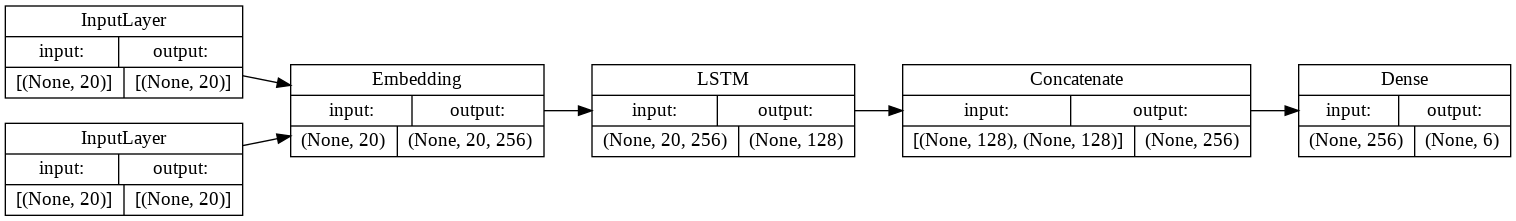

In [ ]:
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
plot_model(
    model, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False, 
    rankdir='LR')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 256)      2560000     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 128)          197120      ['embedding[0][0]',          

In [ ]:
# 決定一次要放多少成對標題給模型訓練
BATCH_SIZE = 512

# 決定模型要看整個訓練資料集幾遍
NUM_EPOCHS = 10

# 實際訓練模型
history = model.fit(
    # 輸入是兩個長度為 20 的數字序列
    x=[x1_train, x2_train], 
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    # 每個 epoch 完後計算驗證資料集
    # 上的 Loss 以及準確度
    validation_data=(
        [x1_val, x2_val], 
        y_val
    ),
    # 每個 epoch 隨機調整訓練資料集
    # 裡頭的數據以讓訓練過程更穩定
    shuffle=True
)

RuntimeError: ignored

In [ ]:
# 以下步驟分別對新聞標題 A、B　進行
# 文本斷詞 / Word Segmentation
test['title1_tokenized'] = \
    test.loc[:, 'title1_zh'] \
        .apply(jieba_tokenizer)
test['title2_tokenized'] = \
    test.loc[:, 'title2_zh'] \
        .apply(jieba_tokenizer)

# 將詞彙序列轉為索引數字的序列
x1_test = tokenizer \
    .texts_to_sequences(
        test.title1_tokenized)
x2_test = tokenizer \
    .texts_to_sequences(
        test.title2_tokenized)

# 為數字序列加入 zero padding
x1_test = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(
        x1_test, 
        maxlen=MAX_SEQUENCE_LENGTH)
x2_test = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(
        x2_test, 
        maxlen=MAX_SEQUENCE_LENGTH)    

# 利用已訓練的模型做預測
predictions = model.predict(
    [x1_test, x2_test])

AttributeError: ignored

In [ ]:
predictions[:5]

In [ ]:
index_to_label = {v: k for k, v in label_to_index.items()}

test['Category'] = [index_to_label[idx] for idx in np.argmax(predictions, axis=1)]

submission = test.loc[:, ['Category']].reset_index()

submission.columns = ['Id', 'Category']
submission.head()